In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn import svm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import svm

from scipy import stats
from math import sqrt
from scipy.stats import norm
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv("MDA8.csv")
data.head(10)

,Date,MDA8
0,01-01-15,42.68
1,02-01-15,39.02
2,03-01-15,15.87
3,04-01-15,19.40
4,05-01-15,65.12
5,06-01-15,63.95
6,07-01-15,28.49
7,08-01-15,13.72
8,09-01-15,52.99
9,10-01-15,34.53


In [3]:
print(data.shape)
data.describe()

(2192, 2)


,MDA8
count,2192.000000
mean,98.530397
std,59.610096
min,3.930000
25%,53.572500
50%,84.365000
75%,140.390000
max,286.470000


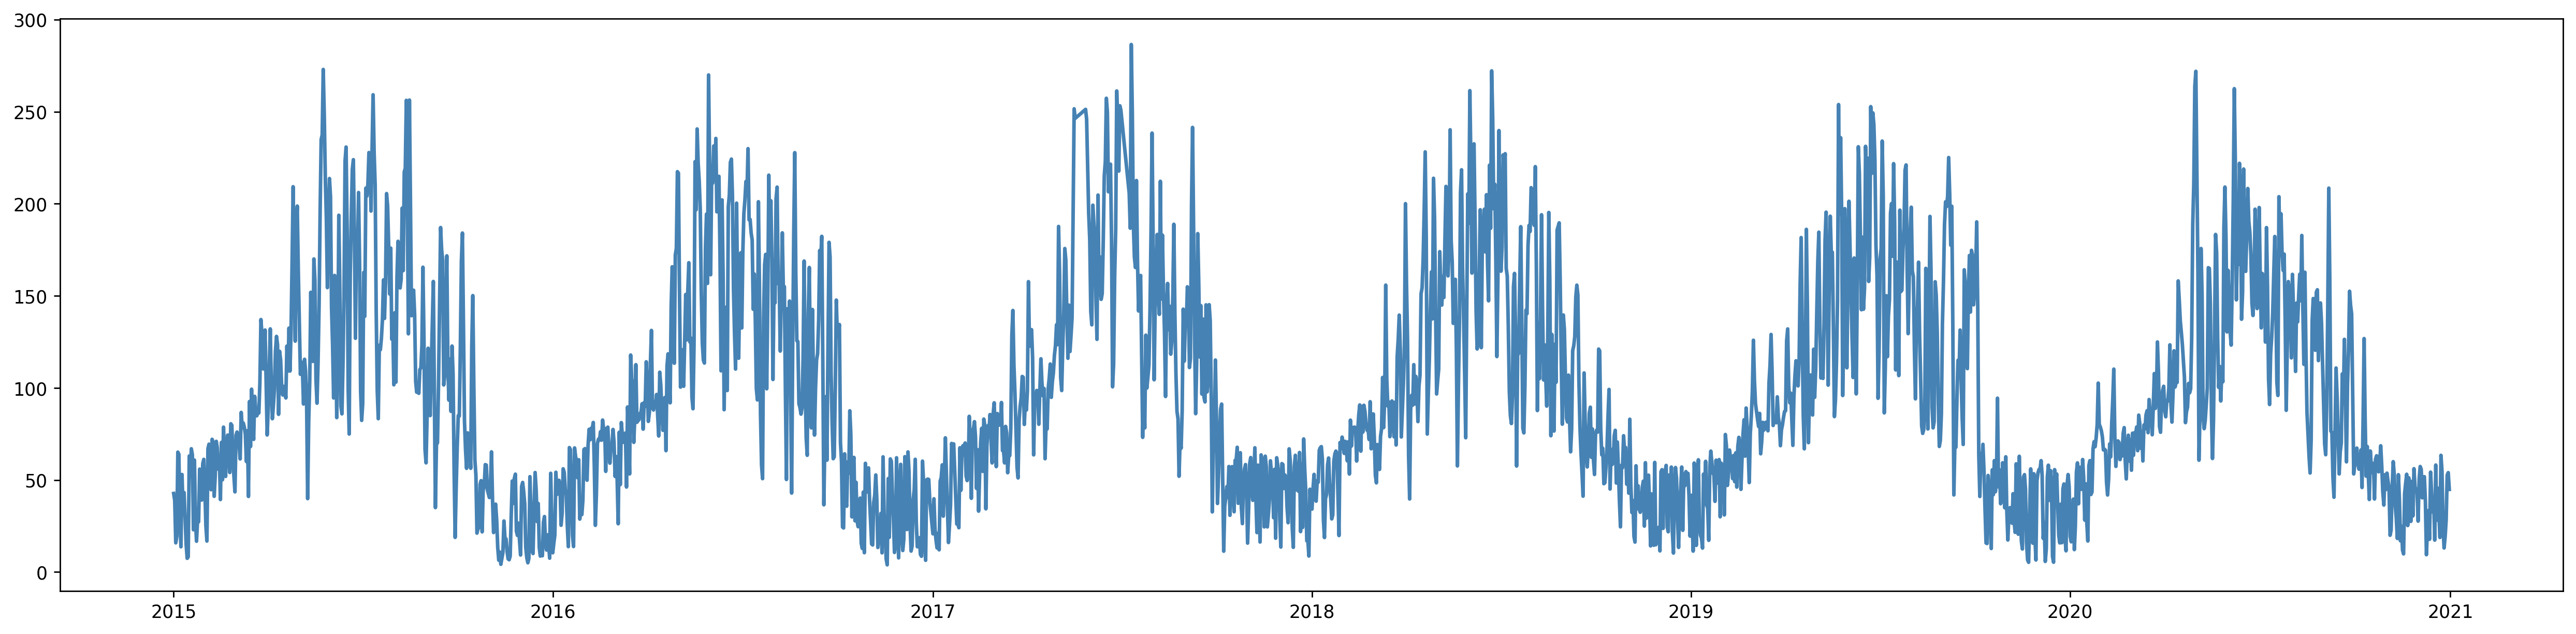

In [4]:
# # Convert 'Date' column to datetime format
data['Date'] = data['Date'].apply(lambda x: datetime.strptime(x, '%d-%m-%y'))
dates = data['Date'].copy() # to be used in further plots

# Sort the dataset by 'Date' in ascending order
data = data.sort_values('Date')

# Create the plot
plt.figure(figsize=(20, 5), dpi=250)

# Plot the ozone data
plt.plot(data['Date'], data['MDA8'], color='steelblue', linewidth=2, label='MDA8 Ozone')

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
## set index
data = data.set_index('Date')
data

,MDA8
Date,
2015-01-01,42.68
2015-01-02,39.02
2015-01-03,15.87
2015-01-04,19.40
2015-01-05,65.12
...,...
2020-12-27,19.13
2020-12-28,28.29
2020-12-29,52.64


In [8]:
def training_test_data():
    training_size = int(len(data)*0.83)  ## ~i need 1 year as Training
    train_data = data.iloc[:training_size]
    test_data = data.iloc[training_size:]
    return train_data, test_data

train_data, test_data = training_test_data()
print(train_data.shape, test_data.shape)

(1819, 1) (373, 1)


In [9]:
## Data Transformation
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [10]:
train_df = pd.DataFrame(train_scaled)
train_df.head(15)

,0
0,0.137149
1,0.124195
2,0.042260
3,0.054753
4,0.216571
5,0.212430
6,0.086926
7,0.034650
8,0.173639
9,0.108303


In [11]:
test_df = pd.DataFrame(test_scaled)
test_df.head(15)

,0
0,0.146032
1,0.155376
2,0.052524
3,0.026934
4,0.153961
5,0.173498
6,0.150032
7,0.054789
8,0.044242
9,0.069371


In [12]:
## Now create an input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)

LOOK_BACK = 7 # Correct according to model / hypertuning

X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape) 
print('y_test.shape:', y_test.shape)

X_train.shape: (1812, 7, 1)
y_train.shape: (1812, 1)
X_test.shape: (366, 7, 1)
y_test.shape: (366, 1)


In [13]:
X_train_df = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_train_df = pd.DataFrame(X_train_df)
X_train_df.head(15)

,0,1,2,3,4,5,6
0,0.137149,0.124195,0.042260,0.054753,0.216571,0.212430,0.086926
1,0.124195,0.042260,0.054753,0.216571,0.212430,0.086926,0.034650
2,0.042260,0.054753,0.216571,0.212430,0.086926,0.034650,0.173639
3,0.054753,0.216571,0.212430,0.086926,0.034650,0.173639,0.108303
4,0.216571,0.212430,0.086926,0.034650,0.173639,0.108303,0.138989
5,0.212430,0.086926,0.034650,0.173639,0.108303,0.138989,0.090961
6,0.086926,0.034650,0.173639,0.108303,0.138989,0.090961,0.039286
7,0.034650,0.173639,0.108303,0.138989,0.090961,0.039286,0.012494
8,0.173639,0.108303,0.138989,0.090961,0.039286,0.012494,0.015290
9,0.108303,0.138989,0.090961,0.039286,0.012494,0.015290,0.209209


In [14]:
X_test_df = X_test.reshape((X_test.shape[0], X_test.shape[1]))
X_test_df = pd.DataFrame(X_test_df)
X_test_df.head(15)

,0,1,2,3,4,5,6
0,0.146032,0.155376,0.052524,0.026934,0.153961,0.173498,0.150032
1,0.155376,0.052524,0.026934,0.153961,0.173498,0.150032,0.054789
2,0.052524,0.026934,0.153961,0.173498,0.150032,0.054789,0.044242
3,0.026934,0.153961,0.173498,0.150032,0.054789,0.044242,0.069371
4,0.153961,0.173498,0.150032,0.054789,0.044242,0.069371,0.126283
5,0.173498,0.150032,0.054789,0.044242,0.069371,0.126283,0.029235
6,0.150032,0.054789,0.044242,0.069371,0.126283,0.029235,0.075104
7,0.054789,0.044242,0.069371,0.126283,0.029235,0.075104,0.177922
8,0.044242,0.069371,0.126283,0.029235,0.075104,0.177922,0.195937
9,0.069371,0.126283,0.029235,0.075104,0.177922,0.195937,0.117293


# 1. GRU Model

In [15]:
## Now create an GRU Model
def create_gru(units):
    model = Sequential()
    
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    
    #Compile model
    model.compile(optimizer= "adam", loss="mse")
    return model

model_gru = create_gru(128)
model_gru.summary()

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 20)
    history = model.fit(X_train, y_train, epochs = 200,  
                        validation_split = 0.1,
                        batch_size = 32, shuffle = True, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 128)            50304     
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 149505 (584.00 KB)
Trainable params: 149505 (584.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
51/5

In [16]:
## Inverse transform of the target variable
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [17]:
## ---- Model Prediction ---- ## 

def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)

## ---- Model Evaluation ---- ## 

def evaluation(test, predicted):
    # Calculating and printing the R2 value
    r2 = r2_score(test, predicted)
    print("R2 Value of sequential model:", round(r2, 3))

    # Calculating and printing the MAE score
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error:", round(mae, 2))

    # Calculating and printing the MSE score
    mse = mean_squared_error(test, predicted)
    print("Mean Squared Error:", round(mse, 2))

    # Calculating and printing the RMSE score
    rmse = sqrt(mean_squared_error(test, predicted))
    print("RMSE:", round(rmse, 2))

evaluation(y_test, prediction_gru)

12/12 [==============================] - 1s 4ms/step
R2 Value of sequential model: 0.779
Mean Absolute Error: 18.8
Mean Squared Error: 601.1
RMSE: 24.52


In [19]:
## ---- Define Model Plot ---- ## 

def plot_vs_future_CI(y_test, model_name, prediction):
    mae = mean_absolute_error(y_test, prediction)
    dates_subset = dates[-y_test.shape[0]:]
         
    plt.figure(figsize=(10, 5), dpi=100)
    range_future = len(prediction)
    
    # Define colors for the plot
    test_color = 'steelblue' #can cahnge color in future if required
    pred_color = 'k'
    
    plt.plot(dates_subset, y_test, color=test_color, label="Test data") #linestyle='dashed'
    plt.plot(dates_subset, prediction, color=pred_color, label="Predictions")

    plt.title("Test data vs prediction for " + model_name)
    plt.legend(loc="upper right")
    
    offset1 = 55
    plt.annotate('R$^2$ = {:.3f}'.format(r2_score(y_test, prediction)), xy=(0.95, 0.95), xycoords='axes fraction',
             xytext=(-offset1, -offset1), textcoords='offset points', fontsize=12)
    offset2 = 70
    plt.annotate('RMSE = {:.2f}'.format(sqrt(mean_squared_error(y_test, prediction))), xy=(0.95, 0.95), xycoords='axes fraction',
             xytext=(-offset1, -offset2), textcoords='offset points', fontsize=12)

    plt.xlabel("Time (Days)")
    plt.ylabel("MDA8 O$_3$")

    # Adjust x-axis limits
    plt.xlim(dates_subset.min(), dates_subset.max())
    
    # Set custom colors for legend
    legend_handles = plt.gca().get_legend().legendHandles
    legend_handles[0].set_color(test_color)
    legend_handles[1].set_color(pred_color)
    plt.tight_layout()
    plt.show()

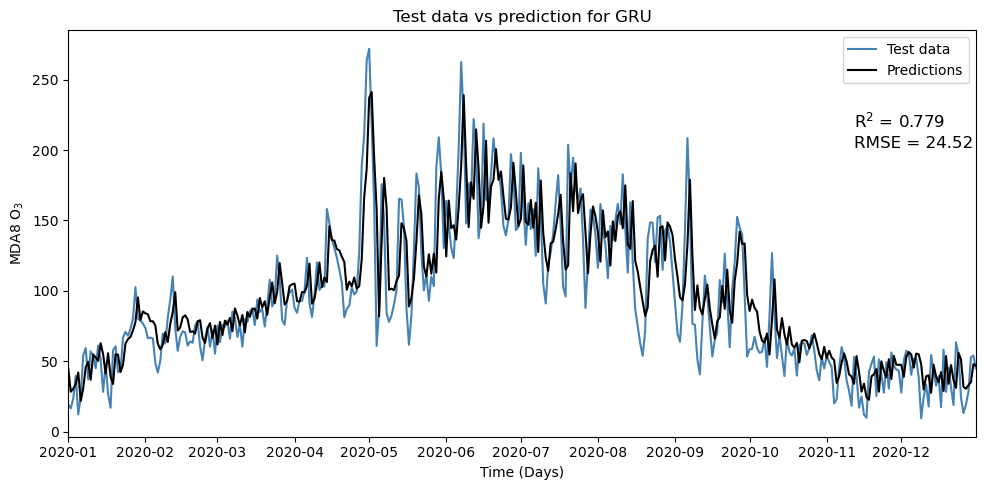

In [20]:
plot_vs_future_CI(y_test, "GRU", prediction_gru)